In [1]:
import pandas as pd
import numpy as np
from patternly.detection import AnomalyDetection
from sklearn.cluster import KMeans

original = pd.read_csv("./01_2015_LANL-01A_SOPA_MPA.txt", low_memory=False).dropna(how="any", axis=0)

In [2]:
START_COL = 0
END_COL = 3
WINDOW_SIZE = 1000
OVERLAP = 800
N_CLUSTERS = 2

predictions = pd.DataFrame()
pipelines = []

for i in range(START_COL, END_COL):
    data = original.iloc[:,i+1].replace(-1e+31, np.nan).dropna(how="all", axis=0)
    seqs = pd.concat(
        [data[
            (j * WINDOW_SIZE - (j * OVERLAP)) : ((j + 1) * WINDOW_SIZE - (j * OVERLAP))
        ].reset_index(drop=True) for j in range(int(data.shape[0] / (WINDOW_SIZE - OVERLAP)))], 
        axis=1
    ).T

    kmeans = KMeans(n_clusters=N_CLUSTERS)
    pipelines.append(
        AnomalyDetection(
            anomaly_sensitivity=1, 
            clustering_alg=kmeans,
            quantize_type="simple",
            eps=0.05,
            verbose=False,
        )
    )
    pipelines[i - START_COL].fit(seqs)

    predictions = pd.concat([predictions, pd.DataFrame(pipelines[i - START_COL].predict())], axis=1)

predictions.columns = range(predictions.shape[1])

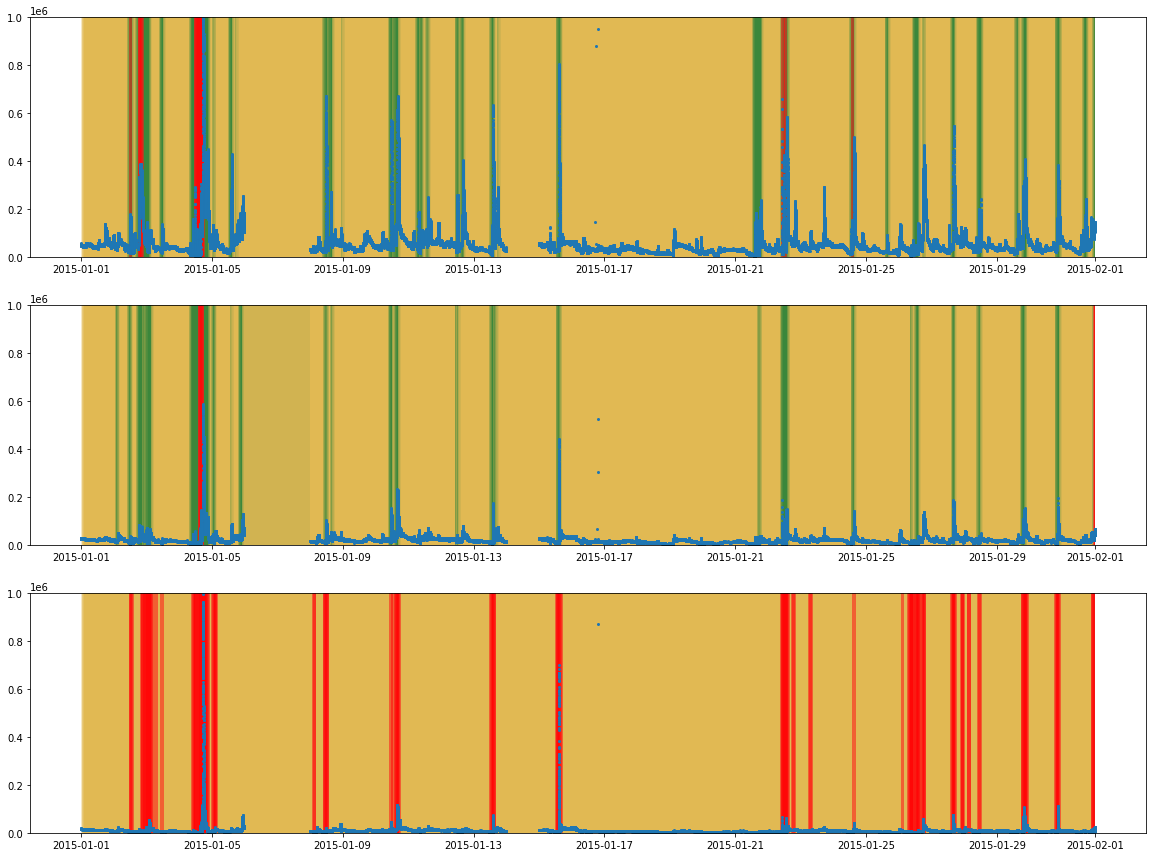

In [7]:
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams["figure.figsize"] = (20,15)

dts = pd.DataFrame(
    [datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f%z") for date in original.iloc[:,0]],
    index=original.index
)

for i in range(START_COL, END_COL):
    # align sequence values with timestamps
    seqs = original.iloc[:,i+1].replace(-1e+31, np.nan).dropna(how="all", axis=0)
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(END_COL-START_COL, 1, i+1-START_COL)
    plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), markersize=2, zorder=2)
    
    # highlight anomalies
    anoms = list(predictions[predictions[i - START_COL] == True].index)
    for index in anoms:
        beg = data["ts"].iloc[(index * WINDOW_SIZE) - (index * OVERLAP)]
        end = data["ts"].iloc[min(((index + 1) * WINDOW_SIZE) - (index * OVERLAP), data["ts"].shape[0] - 1)]
        plt.axvspan(beg, end, color='red', alpha=0.5, lw=0, zorder=1)
    
    # rank clusters for highlighting
    cluster_counts = [0 for j in range(N_CLUSTERS)]
    for cluster in pipelines[i - START_COL].closest_match:
        cluster_counts[cluster] += 1
    cluster_rank = np.full(N_CLUSTERS, N_CLUSTERS - 1, dtype=int) - np.argsort(cluster_counts)
        
    # highlight non-anomalies by cluster
    colors = ["goldenrod", "darkgreen", "purple", "gray"]
    for index in predictions[i][predictions[i] == False].index:
        beg = data["ts"].iloc[(index * WINDOW_SIZE) - (index * OVERLAP)]
        end = data["ts"].iloc[min(((index + 1) * WINDOW_SIZE) - (index * OVERLAP), data["ts"].shape[0] - 1)]
        color = colors[cluster_rank[pipelines[i-START_COL].closest_match[index]]]
        plt.axvspan(beg, end, color=color, alpha=0.25, lw=0, zorder=0)

plt.show()

In [4]:
from IPython.display import Image, display
from IPython.core.display import HTML

# column 1 PFSAs
for i, file in enumerate(pipelines[0].dot_files):
    print(f"Cluster {i}")
    display(Image(url=f"{file}.png", width=300))

Cluster 0


Cluster 1


In [5]:
# column 2 PFSAs
for i, file in enumerate(pipelines[1].dot_files):
    print(f"Cluster {i}")
    display(Image(url=f"{file}.png", width=300))

Cluster 0


Cluster 1


In [6]:
# column 3 PFSAs
for i, file in enumerate(pipelines[2].dot_files):
    print(f"Cluster {i}")
    display(Image(url=f"{file}.png", width=300))

Cluster 0


Cluster 1
